In [1]:
## Satellite Image Classification using Tensorflow

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# import necessary libraries

import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

In [4]:
### 1. PREPARING THE DATASETS

In [5]:
# Downloading and loading the datasets

# laod the whole dataset for data info
all_ds = tfds.load("eurosat", with_info=True)
warnings.filterwarnings('ignore')

In [6]:
# load training, testing and validation sets, splitting by
# 60%, 20% and 20% respectively

train_ds = tfds.load("eurosat", split = "train[:60%]")
test_ds = tfds.load("eurosat", split = "train[60%:80%]")
valid_ds = tfds.load("eurosat", split = "train[80%:]")

In [7]:
# setting some variable names

# the class names 
class_names = all_ds[1].features["label"].names
print(class_names)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [8]:
# total number of classes

num_classes = len(class_names)
print(num_classes)

10


In [9]:
num_examples = all_ds[1].splits["train"].num_examples
print(num_examples)

27000


Text(0.5, 1.0, 'Bar Plot showing Number of Samples on Each Class')

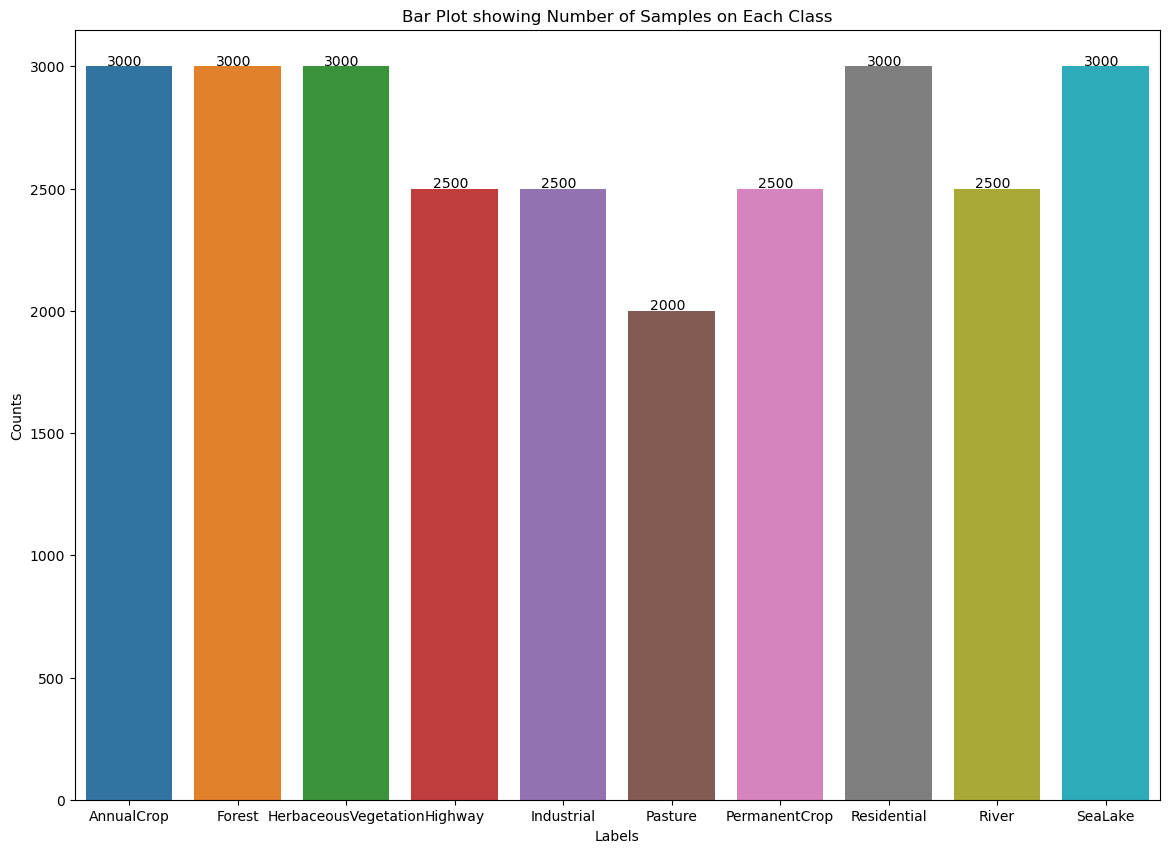

In [10]:
# make a plot for number of samples in each class

# creates a single subplot with a specified size
fig, ax = plt.subplots(1, 1, figsize=(14,10))

# np.unique is used to find the unique labels in the dataset and their corresponding counts
labels, counts = np.unique(np.fromiter(all_ds[0]["train"].map(lambda x: x["label"]), np.int32), 
                       return_counts=True)

plt.ylabel('Counts')
plt.xlabel('Labels')

# seaborn library is used to create the bar plot
sns.barplot(x = [class_names[l] for l in labels], y = counts, ax=ax) 

# loop to add text labels above each bar
for i, x_ in enumerate(labels):
  ax.text(x_-0.2, counts[i]+5, counts[i])

# set the title
ax.set_title("Bar Plot showing Number of Samples on Each Class")

# save the image
# plt.savefig("class_samples.png")

In [11]:
# From the plot above we can see that there are 5 classes with 3000 samples each,
# 4 classes wth 2500 samples and only pasture having 2000 samples.

In [12]:
# In this step, we are going to take our training and validation sets
# and prepare them before training

# Lets create a function to prepare a dataset for training a ML model using TF

def prepare_for_training(ds, cache=True, batch_size=64, shuffle_buffer_size=1000):
    if cache:
        if isinstance (cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    ds = ds.map(lambda d: (d["image"], tf.one_hot(d["label"], num_classes))) 
    
    # shuffle the dataset
    ds = ds.shuffle(buffer_size = shuffle_buffer_size)
    
    # Repeat forever
    ds = ds.repeat()
    
    # split to batches
    ds = ds.batch(batch_size)
    
    # 'prefetch' lets the dataset fetch batches in the background while the
    # model us training - helps to reduce the training time by minimizing
    # the idle time spent waiting for data to be loaded
    
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    return ds

In [13]:
# Run the function for training and validation sets:

batch_size = 64

# Larger batch size can lead to faster training times but may require more memory
# Smaller batch size may generalize better but can result in longer training times
# typical value ranges from 16 to 512 - commonly 64 is used

train_ds = prepare_for_training(train_ds, batch_size = batch_size)
valid_ds = prepare_for_training(valid_ds, batch_size = batch_size)

In [14]:
# Lets check how the data looks like

# validating shapes

for el in valid_ds.take(1):
    print(el[0].shape, el[1].shape)

for el in train_ds.take(1):
    print(el[0].shape, el[1].shape)

# Note: 
# take(1) - iterates over the first element in the validation dataset
# then, prints the shape of the input data and the target or label data


(64, 64, 64, 3) (64, 10)
(64, 64, 64, 3) (64, 10)


In [15]:
# the output above:
# (batch_size, height, weight, color channels) - h/w in pixels
# (batch_size, number_of_classes(one-hot encoded labels))

In [16]:
# take the first batch of training set

batch = next(iter(train_ds))

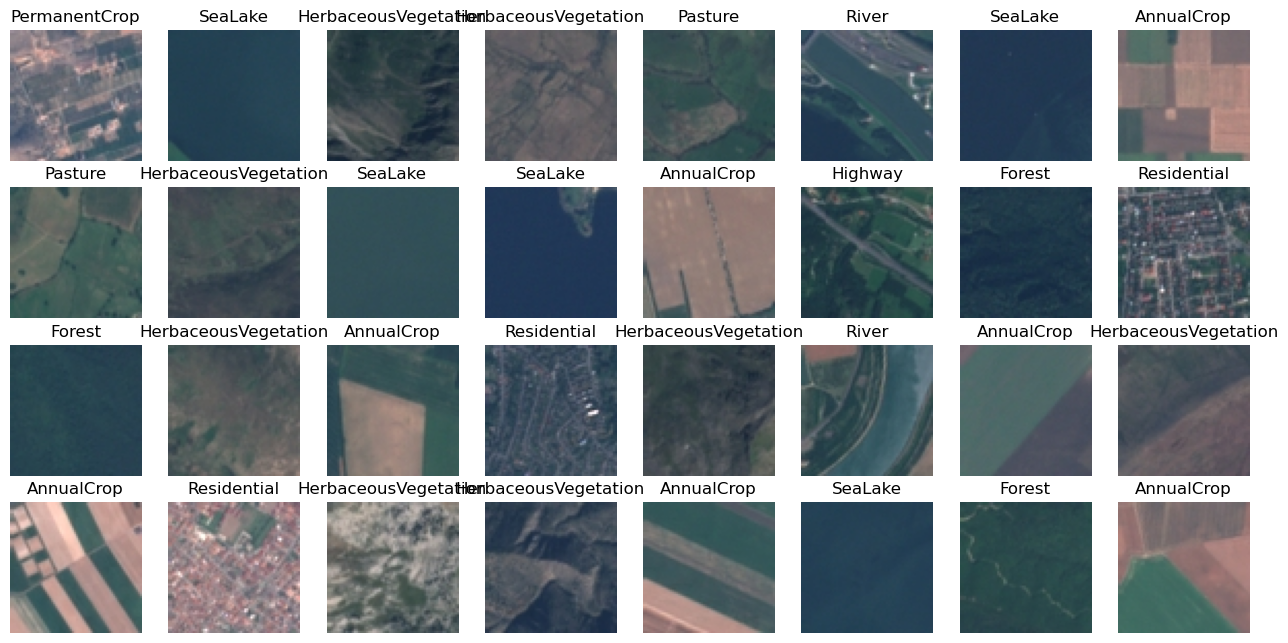

In [17]:
# we are going to visualize the batch of images

def show_batch(batch):
    plt.figure(figsize=(16, 16))
    for n in range(min(32, batch_size)):
        ax = plt.subplot(batch_size//8, 8, n+1)
        
        # show the image
        plt.imshow(batch[0][n])
        
        # and put the corresponding label as title upper to the image
        plt.title(class_names[tf.argmax(batch[1][n].numpy())])
        plt.axis('off')
        plt.savefig("sample_images.png")
        
# showing a batch of images along with labels
show_batch(batch)
        

In [18]:
### 2. BUILDING THE MODEL

In [19]:
# after the preparation of data for training, let's build our model

model_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/2"

# download & load the layer as a feature vector
keras_layer = hub.KerasLayer(model_url, output_shape=[1280], trainable=True)

In [32]:
import tensorflow as tf
from sklearn.metrics import f1_score

m = tf.keras.Sequential([
  keras_layer,
  tf.keras.layers.Dense(num_classes, activation="softmax")
])

# build the model with input image shape as (64, 64, 3)
m.build([None, 64, 64, 3])

# Define a custom F1 score metric using sklearn
def f1_metric(y_true, y_pred):
    y_pred_labels = tf.argmax(y_pred, axis=1)
    f1 = f1_score(tf.argmax(y_true, axis=1), y_pred_labels, average='macro')
    return f1

# Add the custom F1 score metric to the model
m.metrics_names.append('f1_score')
m.compile(loss="categorical_crossentropy", 
          optimizer="adam", 
          metrics=["accuracy", f1_metric])



# Note: This code defines and compiles a Keras Sequential model for image classification. 
# The model uses a pre-trained model as a feature extractor followed by a Dense layer for classification,
# and it is compiled with appropriate loss and evaluation metrics for training.

ValueError: Only instances of `keras.Layer` can be added to a Sequential model. Received: <tensorflow_hub.keras_layer.KerasLayer object at 0x00000194344B02E0> (of type <class 'tensorflow_hub.keras_layer.KerasLayer'>)

In [33]:
m.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda_6 (Lambda)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,810 (50.04 KB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 0 (0.00 B)